In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

import matplotlib.pyplot as plt

def view_single_distribution(
    df,
    metric="area",
    bins=50,
    density=True,
    ax=None,
    title_prefix=""
):
    """
    View a histogram of a single metric from a DataFrame containing
    columns like: ['video', 'frame', 'area', 'eccentricity', 'solidity', 'perimeter'].

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): Which column to visualize, e.g. 'area', 'eccentricity', 'solidity', 'perimeter'.
        bins (int): Number of histogram bins.
        density (bool): Whether to normalize the histogram (density=True) or show counts (density=False).
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes to plot on. 
            If None, a new figure/axes is created.
        title_prefix (str, optional): An optional prefix added to the plot title (e.g. "Real" or "Generated").

    Returns:
        matplotlib.axes.Axes: The axes on which the histogram was plotted.
    """
    if metric not in df.columns:
        raise ValueError(
            f"Metric '{metric}' not found in DataFrame columns. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Drop any NaN or invalid values
    values = df[metric].dropna()

    # Create new figure/axes if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram
    ax.hist(values, bins=bins, alpha=0.7, edgecolor="black", density=density)
    ax.set_title(f"{title_prefix} {metric.capitalize()} Distribution")
    ax.set_xlabel(metric)
    ax.set_ylabel("Density" if density else "Count")

    return ax

def compare_distributions_wasserstein(df_real, df_gen, metric):
    """Compute Wasserstein distance for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    return wasserstein_distance(real_values, gen_values)

def compare_distributions_ks(df_real, df_gen, metric):
    """Compute KS statistic for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ks_stat, ks_pval = ks_2samp(real_values, gen_values)
    return ks_stat, ks_pval

def plot_overlaid_histograms(df_real, df_gen, metric, ax, bins=50):
    """Plot two overlaid histograms for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ax.hist(real_values, bins=bins, alpha=0.5, label="Real", density=True)
    ax.hist(gen_values,  bins=bins, alpha=0.5, label="Generated", density=True)
    ax.set_xlabel(metric)
    ax.set_ylabel("Density")
    ax.legend()

In [2]:
dfs = {
    "real": pd.read_csv("../results/checkpoint-900-val-old/all_morphology.csv"),
    "baseline": pd.read_csv("../results/i2v_baseline/all_morphology.csv"),
    "r64_250": pd.read_csv("../results/i2v_r64_250/all_morphology.csv"),
    "r64_500": pd.read_csv("../results/i2v_r64_500/all_morphology.csv"),
    "r64_750": pd.read_csv("../results/i2v_r64_750/all_morphology.csv"),
    "r64_900": pd.read_csv("../results/i2v_r64_900/all_morphology.csv"),
    "r128_250": pd.read_csv("../results/i2v_r128_250/all_morphology.csv"),
    "r128_500": pd.read_csv("../results/i2v_r128_500/all_morphology.csv"),
    "r128_750": pd.read_csv("../results/i2v_r128_750/all_morphology.csv"),
    "r128_900": pd.read_csv("../results/i2v_r128_900/all_morphology.csv"),
    "r256_250": pd.read_csv("../results/i2v_r256_250/all_morphology.csv"),
    "r256_375": pd.read_csv("../results/i2v_r256_375/all_morphology.csv"),
    "r256_750": pd.read_csv("../results/i2v_r256_750/all_morphology.csv"),
    "r256_900": pd.read_csv("../results/i2v_r256_900/all_morphology.csv"),
}

In [8]:
skip_frames = 40  # Change this value as needed
print(f"Filtering out first {skip_frames} frames from each video")

# Store original sizes to report filtering stats
original_sizes = {name: len(df) for name, df in dfs.items()}

# Filter each DataFrame to remove early frames
filtered_dfs = {}
for name, df in dfs.items():
    filtered_dfs[name] = df[df['frame'] >= skip_frames]
    
    # Report how many nuclei were filtered out
    before = original_sizes[name]
    after = len(filtered_dfs[name])
    print(f"{name}: removed {before - after} nuclei ({(before - after) / before:.1%})")

# Replace original dfs with filtered ones
dfs = filtered_dfs

Filtering out first 40 frames from each video
real: removed 465957 nuclei (24.3%)
baseline: removed 9202 nuclei (34.6%)
r64_250: removed 48931 nuclei (27.2%)
r64_500: removed 87474 nuclei (30.9%)
r64_750: removed 80642 nuclei (31.4%)
r64_900: removed 82884 nuclei (31.1%)
r128_250: removed 38398 nuclei (24.7%)
r128_500: removed 78787 nuclei (31.9%)
r128_750: removed 74105 nuclei (29.8%)
r128_900: removed 73441 nuclei (30.6%)
r256_250: removed 58115 nuclei (27.9%)
r256_375: removed 66907 nuclei (30.5%)
r256_750: removed 80540 nuclei (29.5%)
r256_900: removed 70143 nuclei (29.8%)


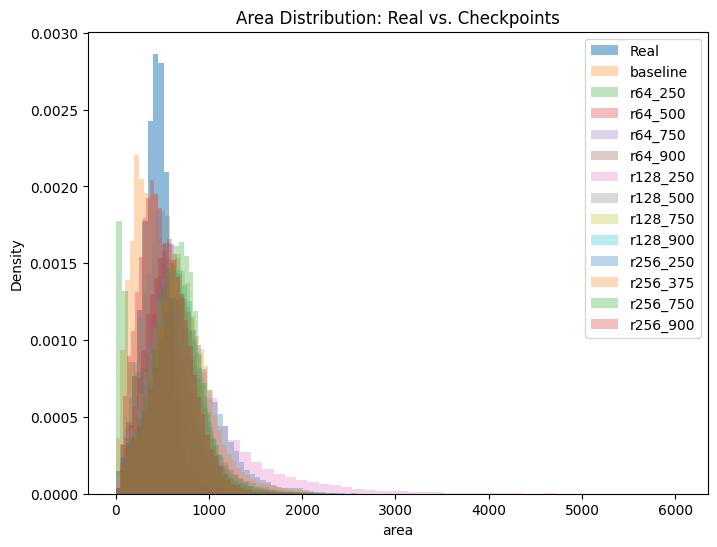

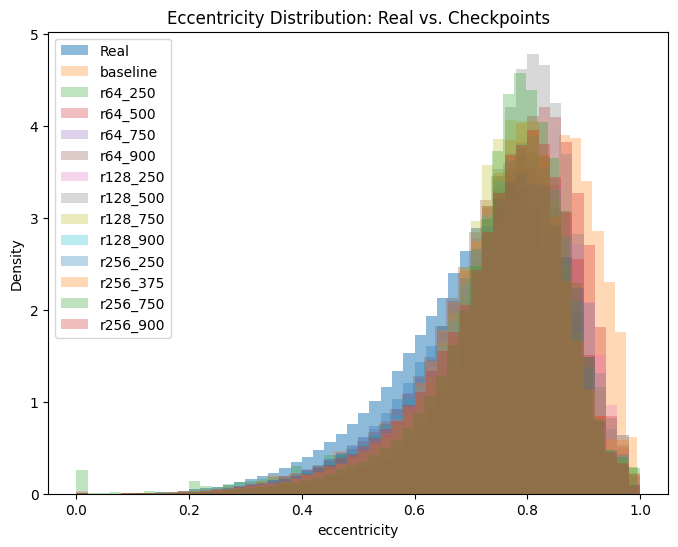

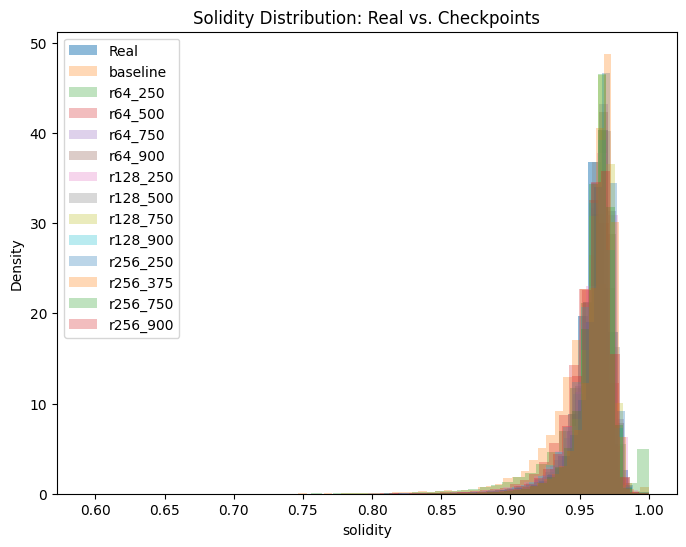

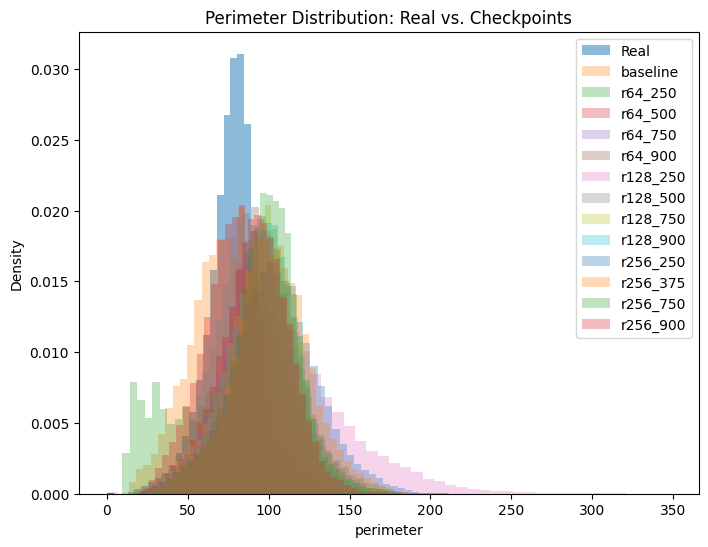

In [9]:
import matplotlib.pyplot as plt

metrics = ["area", "eccentricity", "solidity", "perimeter"]

for metric in metrics:
    plt.figure(figsize=(8,6))
    # Plot real distribution
    plt.hist(dfs["real"][metric].dropna(), bins=50, alpha=0.5, density=True, label="Real")
    
    # Plot each checkpoint overlayed
    for name, df in dfs.items():
        if name == "real":
            continue
        plt.hist(df[metric].dropna(), bins=50, alpha=0.3, density=True, label=name)
    
    plt.title(f"{metric.capitalize()} Distribution: Real vs. Checkpoints")
    plt.xlabel(metric)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [10]:
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp

metrics = ["area", "eccentricity", "solidity", "perimeter"]
results = []

for checkpoint_name, df_gen in dfs.items():
    if checkpoint_name == "real":
        continue
    for metric in metrics:
        real_vals = dfs["real"][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)
        
        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_results = pd.DataFrame(results)
df_results

,checkpoint,metric,wasserstein_distance,ks_stat,ks_pval
0,baseline,area,83.719118,0.250499,0.0
1,baseline,eccentricity,0.074319,0.293576,0.0
2,baseline,solidity,0.011292,0.261067,0.0
3,baseline,perimeter,7.152053,0.187783,0.0
4,r64_250,area,179.190821,0.260987,0.0
5,r64_250,eccentricity,0.042356,0.147278,0.0
6,r64_250,solidity,0.007611,0.124815,0.0
7,r64_250,perimeter,18.550961,0.283569,0.0
8,r64_500,area,48.294097,0.101244,0.0
9,r64_500,eccentricity,0.080300,0.269349,0.0


In [11]:
mean_dists = (
    df_results
    .groupby("checkpoint")["wasserstein_distance"]
    .mean()
    .sort_values()
)
print(mean_dists)

# The top row(s) in this sorted output have the smallest distance on average,
# indicating the best morphological match to real data.

checkpoint
r64_500      13.504051
baseline     22.739195
r128_500     26.333055
r256_900     41.650214
r64_250      49.447937
r64_750      54.075450
r128_750     55.952196
r128_900     56.323505
r64_900      57.130571
r256_750     62.622797
r256_375     79.125456
r256_250     86.862104
r128_250    125.140511
Name: wasserstein_distance, dtype: float64


In [12]:
best = ["r64_500", "r128_500", "r256_900"]

df_results[df_results["checkpoint"].isin(best)].reset_index(drop=True)




,checkpoint,metric,wasserstein_distance,ks_stat,ks_pval
0,r64_500,area,50.289329,0.131479,0.0
1,r64_500,eccentricity,0.073827,0.246757,0.0
2,r64_500,solidity,0.008607,0.209814,0.0
3,r64_500,perimeter,5.519073,0.100845,0.0
4,r128_500,area,57.776741,0.110561,0.0
5,r128_500,eccentricity,0.070514,0.246117,0.0
6,r128_500,solidity,0.004064,0.087249,0.0
7,r128_500,perimeter,6.001879,0.146679,0.0
8,r256_900,area,91.360881,0.215572,0.0
9,r256_900,eccentricity,0.034375,0.116888,0.0
